In [2]:
import scipy
from scipy import interpolate
from scipy import stats
from scipy.optimize import least_squares
import matplotlib.pyplot as pl
import matplotlib.animation as animation
import pickle
import gzip

import numpy as np

%matplotlib inline

In [3]:
# Comsol model of the self heating
model = np.loadtxt('1W_self_heating_defocus_doublepass.txt')

#infile = open('data.p','rb')
#data_p = pickle.load(infile)

itmx = 'data_ITMX.p'
itmy = 'data_ITMY.p'

def open_file(filename):
    with open(str(filename), 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data_p = u.load()
    return data_p

In [95]:
i_ind_x = 40
e_ind_x = -1

i_ind_y = 40
e_ind_y = -1

In [96]:
# each index is 20 seconds

In [97]:
itmx_data_p = open_file(itmx)
itmy_data_p = open_file(itmy)

In [98]:
itmx_data = itmx_data_p[(700,450)]['spherical'][ i_ind_x:e_ind_x ]
itmy_data = itmy_data_p[(700,560)]['spherical'][ i_ind_y:e_ind_y ]

In [99]:
t_vect_x = np.arange(0.,float(len(itmx_data)),1.)
t_vect_x = (t_vect_x*20.)

t_vect_y = np.arange(0.,float(len(itmy_data)),1.)
t_vect_y = (t_vect_y*20.)

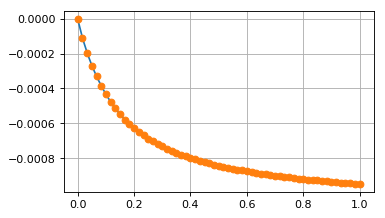

In [100]:
time_model = model[:,0]
abs_model  = model[:,1]

def TL(x,a,b):    
    y = interpolate.interp1d(time_model,-abs_model/1e6,fill_value="extrapolate")
    ynew = y(x)
    return a + (b * ynew)

a=0.0
b=1.0
x = np.arange(0,1,.001) #hours
f = TL(x,a,b)

#### Plot
pl.figure(figsize=(5, 3), dpi=80)
pl.plot(x,f)
pl.plot(time_model,-abs_model/1e6, 'o')
pl.grid()
pl.show()


In [101]:
# Fit Data
p_in=22
prc_g = 47.0
bs = 0.5
arm_g = 282.0

p_arm = p_in*prc_g*bs*arm_g


def get_abs(t,data,opticname,i,e,plot=True,add_sigs=None):
    
    time_ix = t[i:e] - t[i]
    data_ix = data[i:e] - data[i]

    
    time_ix = time_ix/3600
    
    data_start_avg = data_ix[0]#rescale start to zero, guess
    data_ix = data_ix - data_start_avg
    
    
    if add_sigs is None:
        [opt,b]=scipy.optimize.curve_fit(TL,time_ix,data_ix)
    else:
        #sigs = np.logspace(2,.0001,len(time_ix))
        tau=0.2
        sigs=np.exp(-time_ix/tau)
        [opt,b]=scipy.optimize.curve_fit(TL,time_ix,data_ix,sigma=sigs,absolute_sigma=True)
        
        pl.figure(figsize=(10, 8), dpi=80)
        pl.subplot(211)
        pl.plot(time_ix,sigs)
        pl.grid()
        

    arm_abs = 1e9*opt[1]/p_arm #scale to get the absorption in ppm
    print(arm_abs)
    perr = np.sqrt(np.diag(b))
    print(perr)
    
    if plot is True:
        pl.figure(figsize=(10, 5), dpi=300)
        pl.subplot(111)
        pl.plot(time_ix,data_ix*1e6,label="Data")
        pl.plot(time_ix,TL(time_ix,opt[0],opt[1])*1e6,label="Comsol Model",linewidth=3.0)
        pl.ylabel("Spherical Power (uDiopters)",fontsize = 16)
        pl.xlabel("Time After Lockloss (Hours)",fontsize = 16)
        pl.legend(fontsize=16)
        pl.tick_params(labelsize=14)

        #pl.title(opticname + " Abs Estimate = "+str(round(arm_abs,2))+"+/-"+str(round(1e9*rms/p_arm,2)) + "ppb")
        pl.grid()
        
        pl.savefig("../../Figures/"+opticname+"_HWS_Absorption.png")
    
    return arm_abs, perr

344.5282719659223
[6.61564499e-07 9.26792360e-04]


(344.5282719659223, array([6.61564499e-07, 9.26792360e-04]))

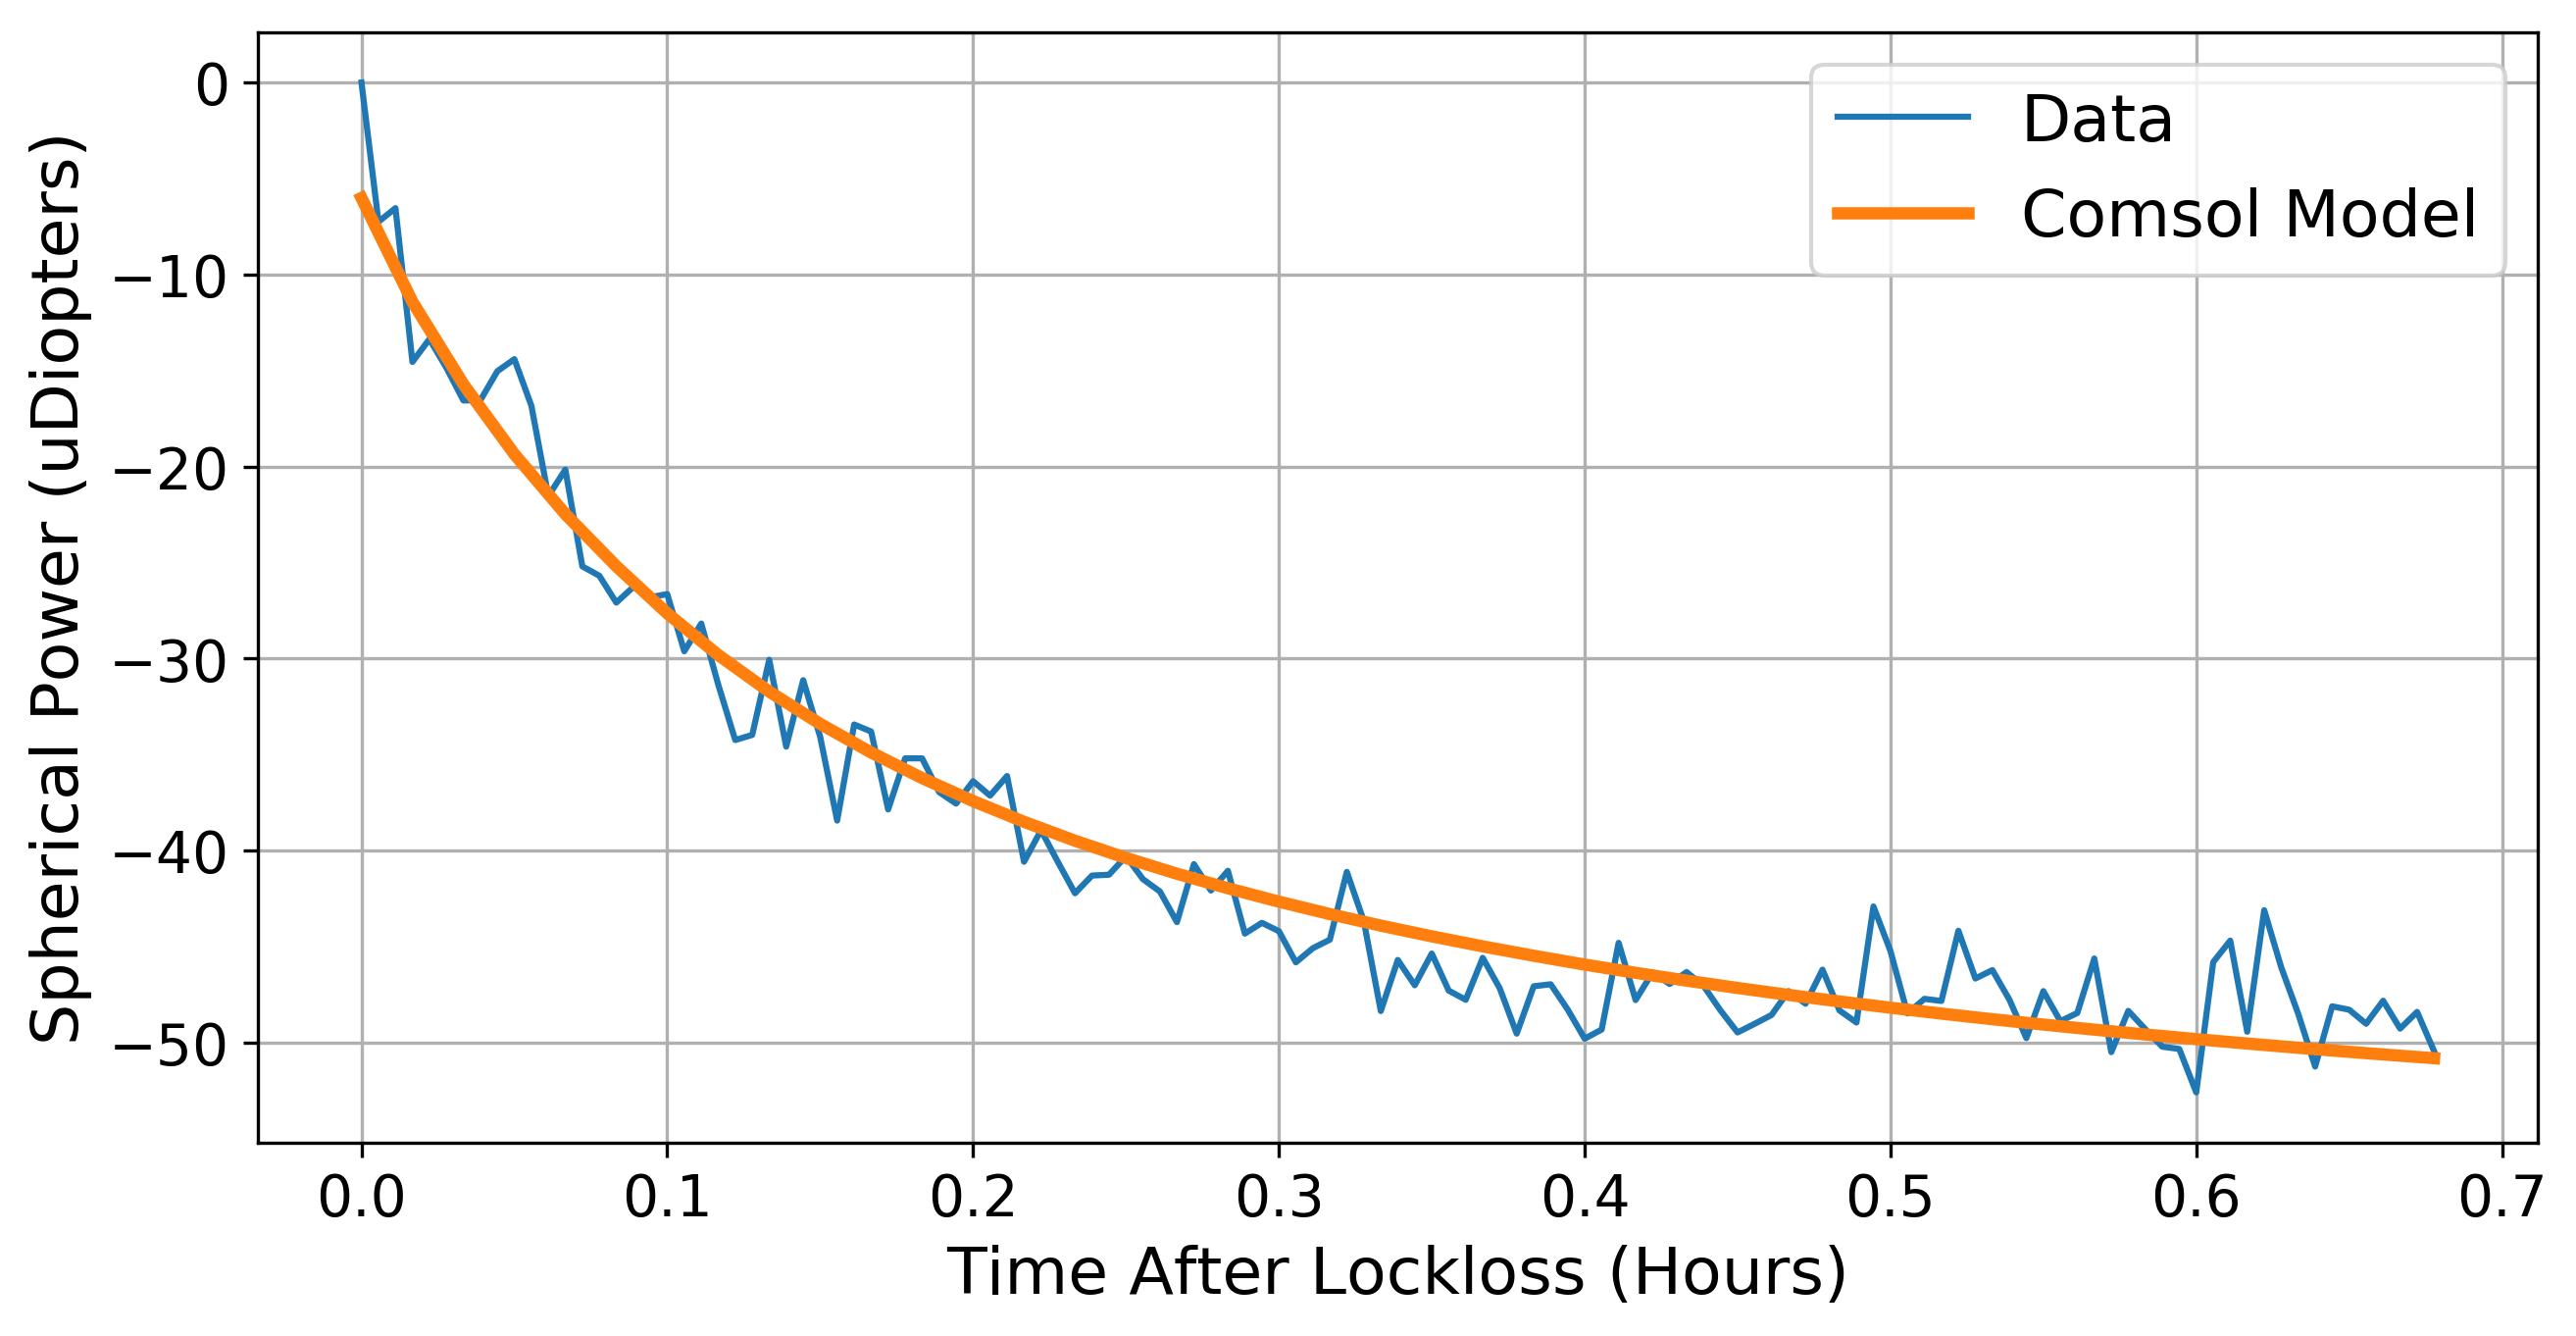

In [102]:
get_abs(t_vect_x,itmx_data,'itmx',i_ind_x,e_ind_x)

804.3988222057642
[7.45036233e-07 1.04372876e-03]


(804.3988222057642, array([7.45036233e-07, 1.04372876e-03]))

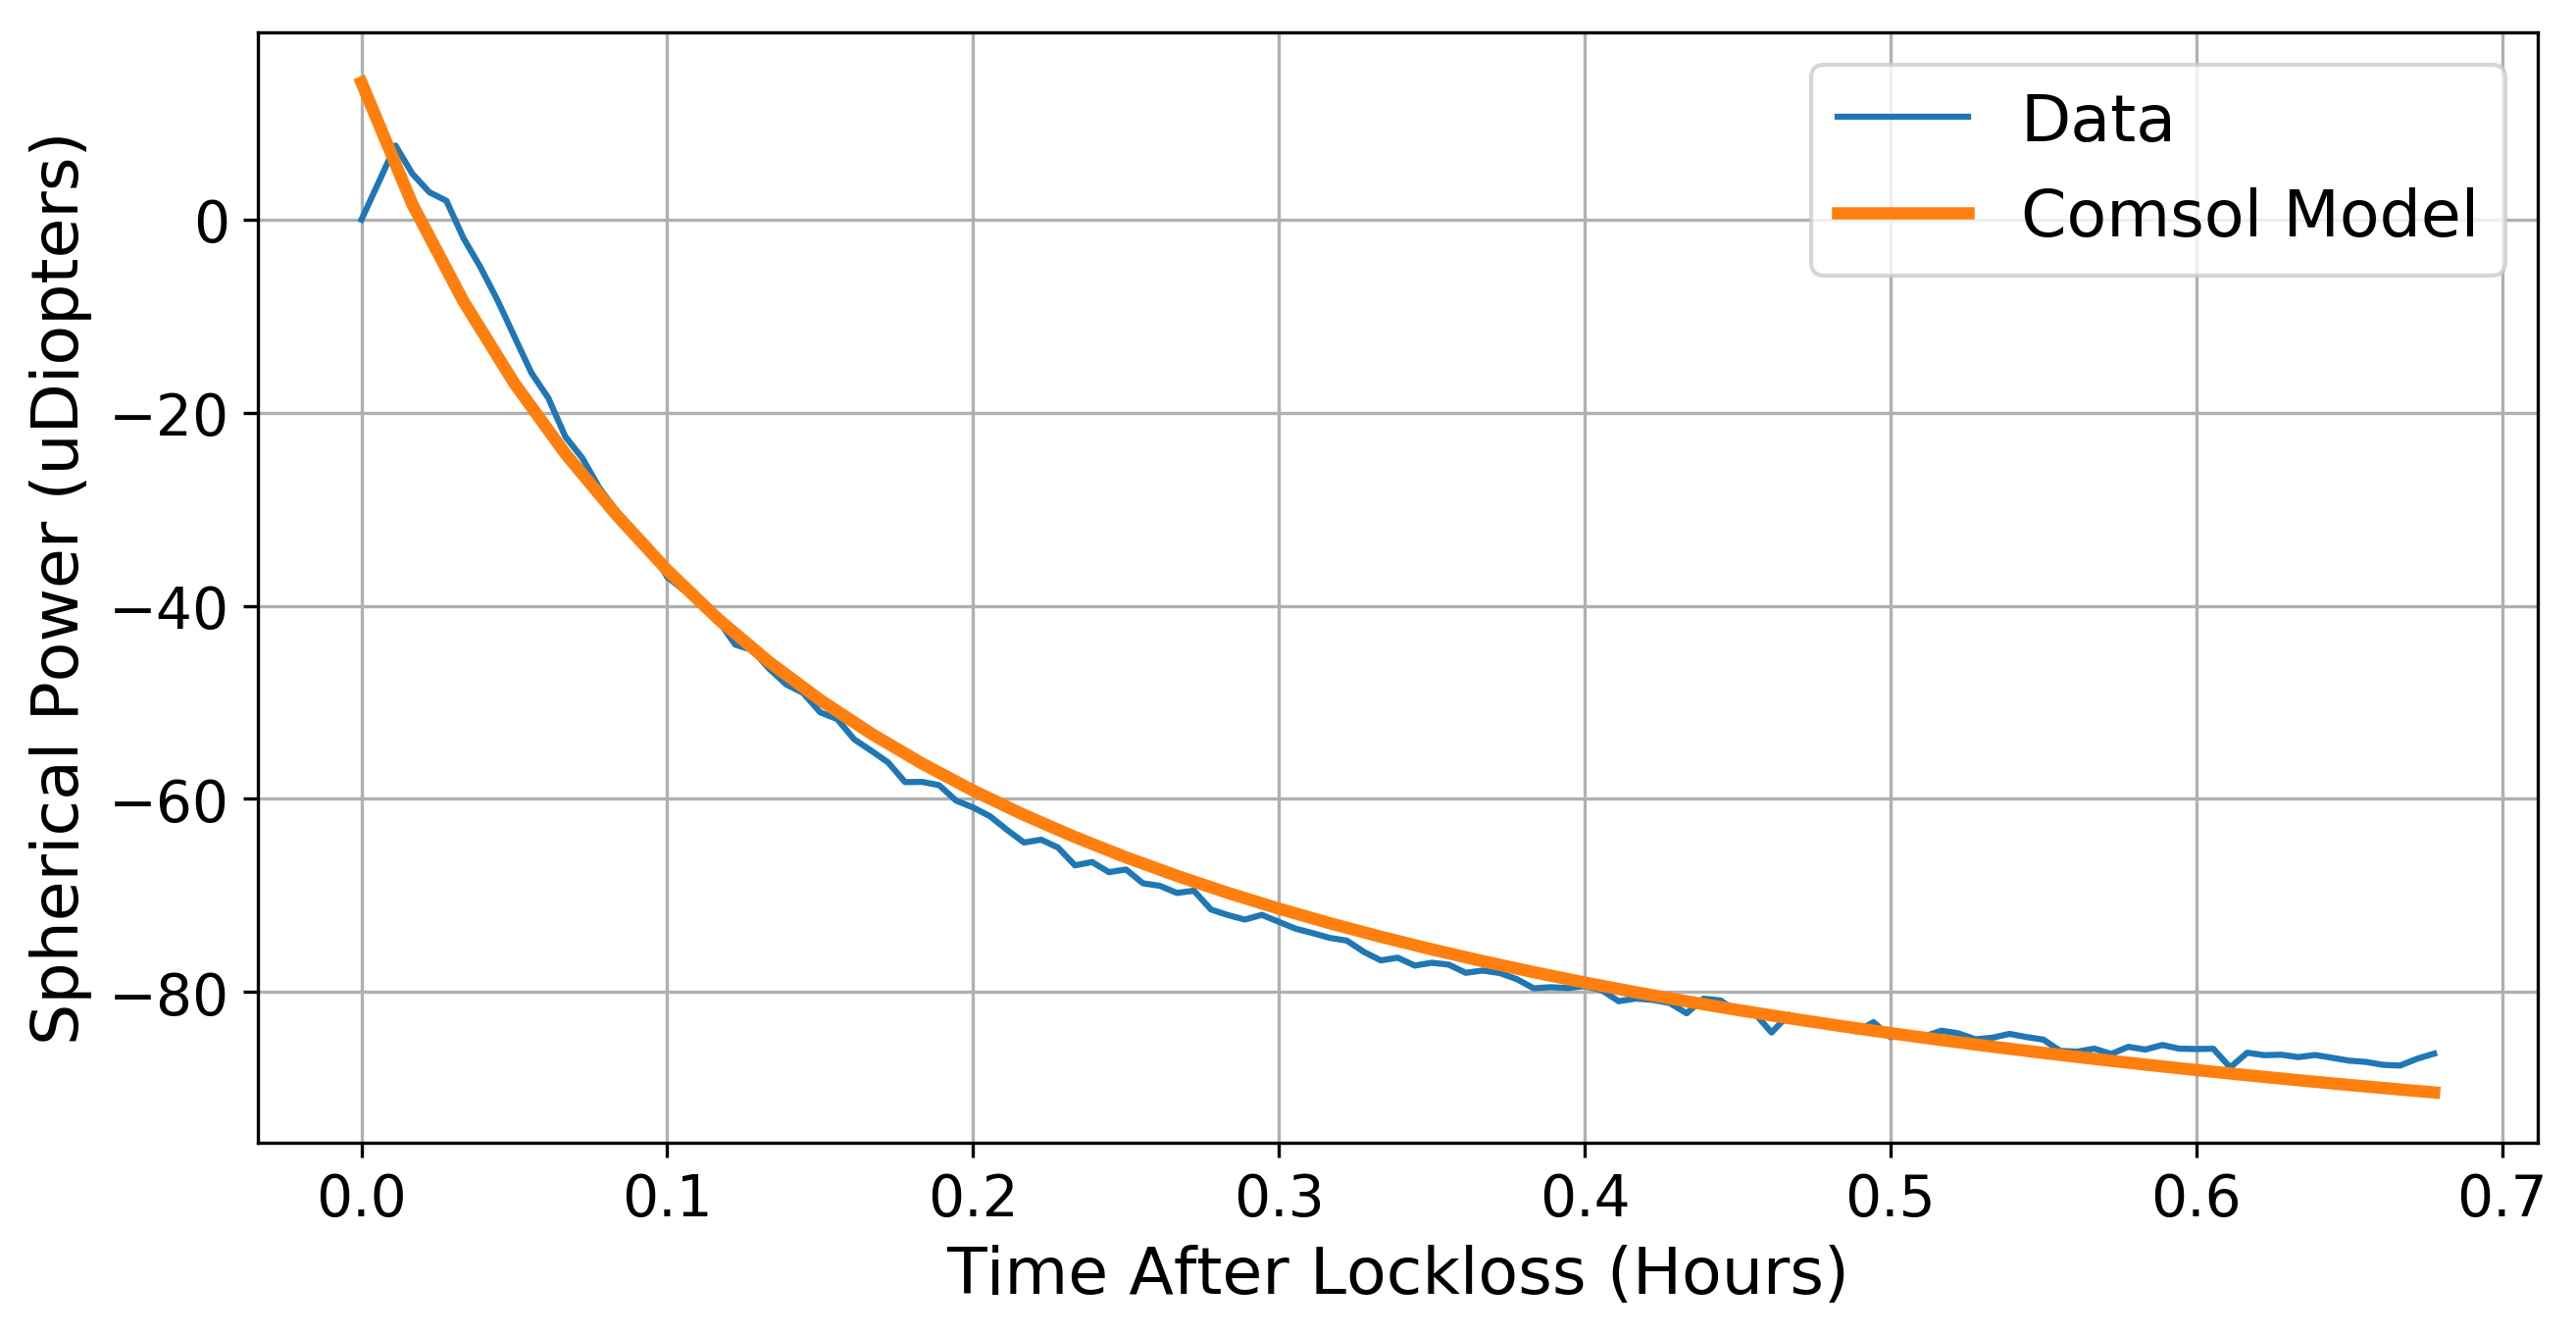

In [103]:
get_abs(t_vect_y,itmy_data,'itmy',i_ind_y,e_ind_y)